# Grundlagen 4: Animation des Gradientenabstiegs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from ki_kurs.polynom import Polynom

%matplotlib widget

### Unser Gradientenabstiegsverfahren (mit Gedächtnis)

Wir erweitern unsere Implementierung des Gradientenabstiegs um ein "Gedächtnis", d.h. wir speichern die berechneten Zwischenergebnisse - Koeffizienten und Gradienten - in einer Liste und geben diese zurück.

In [2]:
def koeff(x,y):
    """ Berechnung der Koeffizienten """
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)
    N = x.shape[0]
    return sum_xx, sum_x, -sum_xy, sum_x, N, -sum_y

def grad(k,a,b):
    """
    Berechnung des Gradienten im Punkt a,b. Die Koeffizienten wurden bereits berechnet
    """
    sum_x2, sum_x, sum_xy, sum_x, N, sum_y = k
    
    dD_da = 2 * (sum_x2 * a +  sum_x *b  + sum_xy)
    dD_db = 2 * (sum_x * a + N * b + sum_y)
    return dD_da, dD_db

def grad_abstieg_anim(x,y,a,b,epsilon=0.001,iterationen=1000):
    k = koeff(x,y)
    res = [(b,a,0,0)]
    for _ in range(iterationen):
        da,db = grad(k,a,b)
        a -= epsilon * da 
        b -= epsilon * db
        res.append((b,a,db,da))

    return np.array(res)

def poly_gen(coeff:np.ndarray):
    return lambda x: np.sum([c * x**k for k,c in enumerate(coeff)])
    
def D(x,y,p):
    """ Die Distanzfunktion berechnet die Fehlerquadratsumme """
    return np.sum((p(x) - y)**2) / len(x)

### Animationsfunktion

Unsere Animationsfunktion stellt die Punktepaare dar sowie die Verschiebung der berechneten Ausgleichsgerade.

In [3]:
class PauseAnimation:
    def __init__(self,x,y,fs,grads,points,speed=100,title=''):
        fig, self.ax = plt.subplots()
        self.ax.grid(True)       
        px,py = points      
        
        self.ax.set_xlim(0,np.max(px)+1)        
        self.ax.set_ylim(0,np.max(py) +1)
        self.ax.set_xlabel('$x$')
        self.ax.set_ylabel('$p(x)$')

        self.ax.set_title(title)
        self.ax.scatter(px,py,c='r')        
        
        self.fs = fs
        self.ys = [ f(x) for f in fs]
        self.grads = grads

        
        self.p, = self.ax.plot(x, self.ys[0])
        self.d = plt.text(5,1,f'D(p) = {D(x,y,self.fs[0]):.3f}')
        self.g = plt.text(5,2.5,f'grad D = {self.grads[0,0]:.3f},{self.grads[0,1]:.3f}')
        self.animation = FuncAnimation(fig, self.update, frames= len(self.fs), interval=speed, blit=True)
     
        self.paused = False

        fig.canvas.mpl_connect('button_press_event', self.toggle_pause)

    def toggle_pause(self, *args, **kwargs):
        if self.paused:
            self.animation.resume()
        else:
            self.animation.pause()
        self.paused = not self.paused

    def update(self, frame): 
        self.p.set_ydata(self.ys[frame])
        self.d.set_text(f'D(p) = {D(x,y,self.fs[frame]):.3f}')
        self.g.set_text(f'grad D(b,a) = ({self.grads[frame,0]:.2f},{self.grads[frame,2]:.1f})')
        return (self.p,self.d,self.g)

### Die animierte Darstellung

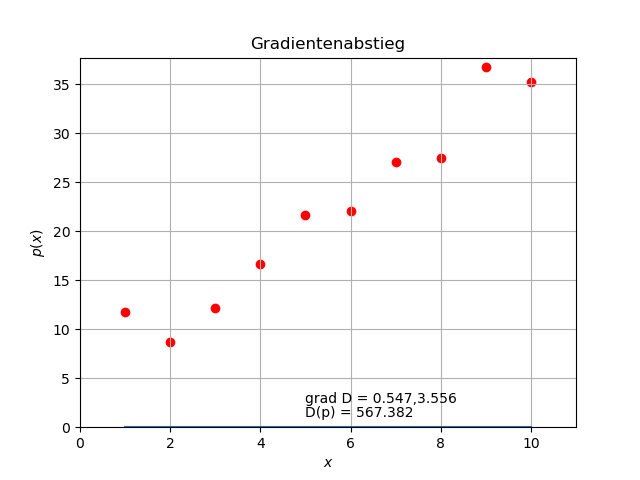

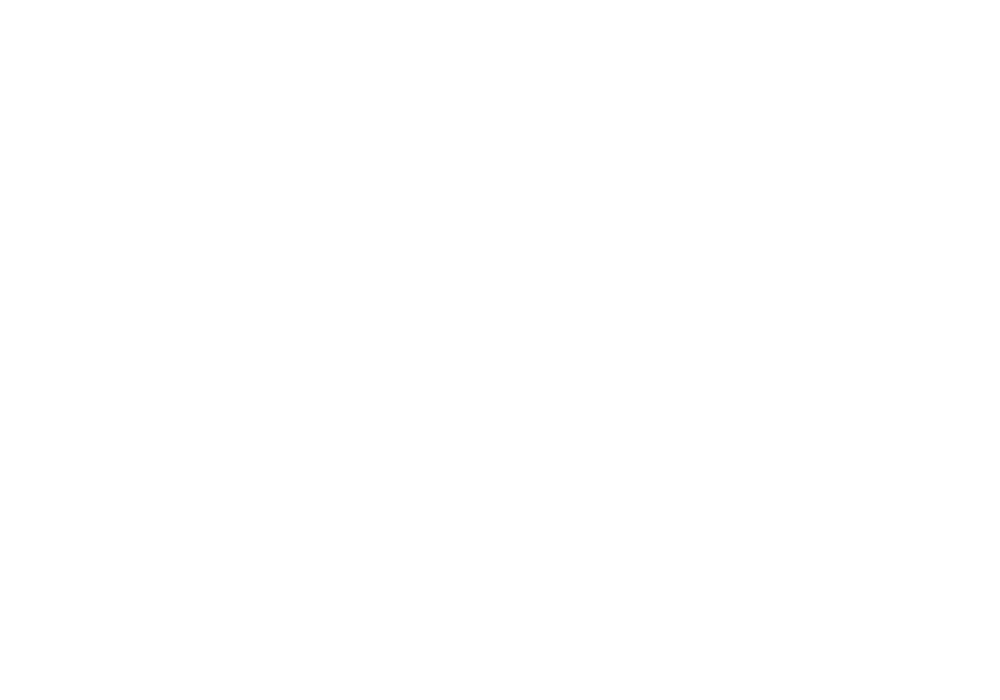

In [4]:
N=10
x = np.linspace(1,10,N)
y = 3 *x + 6 + np.random.normal(0,3,N)
a0, b0 = 0,0

res = grad_abstieg_anim(x,y,a0,b0,epsilon=0.001,iterationen = 20)

ps = [np.vectorize(poly_gen(r[0:2])) for r in res]

grads = res[2:]
plt.figure( figsize=(10, 7))
pa = PauseAnimation(x,y,ps,grads,points = (x,y),speed=1000,title='Gradientenabstieg')
plt.show()